In [2]:
import geopandas as gpd
from matplotlib import pyplot as plt
import cartopy
import pandas as pd
import networkx as nx
import re
import numpy as np

In [3]:
#network from data
original=nx.Graph()

# add nodes
nodes = pd.read_csv("nodes_DE2023_methane.csv")
for i in range(0, nodes.shape[1]):
	# id,name,alias,type,x,y,height
	node = nodes.iloc[i]
	original.add_node(node.id, name=node.name, alias=node.alias, type=node.type, x=node.x, y=node.y, height=node.height)

# add edges
edges = pd.read_csv("edges_DE2023_methane.csv")
for i in range(0, edges.shape[1]):
	#id,node0_id,node1_id,name,alias,type,diameter,length,roughness,rin,rout,pimin,pomax
	edge = edges.iloc[i]
	original.add_edge(edge.node0_id, edge.node1_id, id=edge.id, name=edge.name, alias=edge.alias, type=edge.type, length=edge.length, roughness=edge.roughness, rin=edge.rin, rout=edge.rout, pimin=edge.pimin, pomax=edge.pomax)


In [4]:
# translate every entry in nodes["alias"] to its property, save in nodes["type"]
nodes["type"] = nodes["alias"].copy().apply(lambda x: ''.join(re.findall(r'([A-Z]|[a-z])', str(x).split("_")[0]))).to_numpy()
# fill nan values in nodes["type"] with N
nodes["type"] = nodes["type"].apply(lambda x: "N" if str(x) == "nan" else x)

In [34]:
nuts3 = gpd.read_file("./NUTS3/NUTS_RG_20M_2024_4326.shp").set_index("NUTS_ID")
nuts3 = nuts3[nuts3["LEVL_CODE"] == 3]
nuts3.head(3)

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
NUTS_ID,,,,,,,,
AL011,3,AL,Dibër,Dibër,NaN,NaN,NaN,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,..."
AL012,3,AL,Durrës,Durrës,NaN,NaN,NaN,"POLYGON ((19.55733 41.57767, 19.83218 41.56823..."
AL013,3,AL,Kukës,Kukës,NaN,NaN,NaN,"POLYGON ((20.59429 41.87733, 20.56287 41.84614..."


<GeoAxes: >

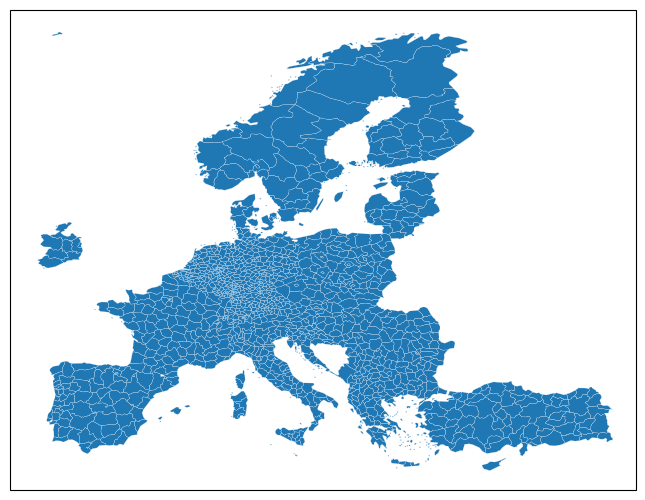

In [49]:
ax = plt.axes(
	[0, 0, 1, 1],
    projection=cartopy.crs.PlateCarree(),
	)

extent = [-13, 47, 33, 73]
ax.set_extent(extent, cartopy.crs.PlateCarree())

nuts3.plot(
	ax=ax,
	edgecolor='white',
	linewidth=0.15,

	)

In [7]:
#Complexity
def complexity(simplified:nx.Graph):
    # calculate node count score
    nodes_score = simplified.number_of_nodes() / original.number_of_nodes()
    
    # calculate edge count score
    edges_score = simplified.number_of_edges() / original.number_of_edges()
    
    # calculate average degree score
    original_avg_degree = sum([x[1] for x in nx.degree(original)]) / len(nx.degree(original))
    simplified_avg_degree = sum([x[1] for x in nx.degree(simplified)]) / len(nx.degree(simplified))
    avg_degree_score = simplified_avg_degree / original_avg_degree

    # average the three complexity scores and return result
    return 1 - ((nodes_score + edges_score + avg_degree_score) / 3)

complexity(original)

0.0

In [50]:
#Structure
def structure():
	return 0

print(structure())

0


In [ ]:
#Regionality: Keep many regions connected to the network

def count_regions(df:pd.DataFrame):
	# create dataframe from nodes["id"], nodes["x"], nodes["y"]
	df = gpd.GeoDataFrame(df["id"].copy())
	df = df.set_geometry(gpd.points_from_xy(nodes["x"], nodes["y"]), crs="EPSG:3035").to_crs("EPSG:4326")

	# merge nuts regions file with id-point dataframe
	df = df.sjoin(nuts3, how="left", predicate='within')

	# reduce merged dataframe to unique regions with number of nodes per region
	df = df.value_counts("NUTS_ID")

	# filter for rows, that contain regions with nodes
	df = df[df > 0]

	# count number of lines
	return df.size

def regionality(simplified:pd.DataFrame):
	# calculate score from difference in number of regions
	return count_regions(simplified) / count_regions(nodes)

print(regionality(nodes))

1.0


In [ ]:
#Properties: Keep important nodes
def properties(df:pd.DataFrame):
    # calculate properties score from 
    return properties_df(df) / properties_df(nodes)
    
def properties_df(df:pd.DataFrame):
    # count how often each unique element occurs
    count = df["type"].value_counts().reset_index()
    # count node types, apply weights, add weighted count
    score = 0
    for i in range(0, count.shape[1]):
        match count["type"].iloc[i]:
            case "DSO": score += count["count"].iloc[i]
            case "IND": score += count["count"].iloc[i]
            case "TPP": score += count["count"].iloc[i]*0.75
            case "BIO": score += count["count"].iloc[i]*0.25
            case "GPR": score += count["count"].iloc[i]*0.25
            case "GS": score += count["count"].iloc[i]
            case "FUEL": score += count["count"].iloc[i]*0
            case "LNG": score += count["count"].iloc[i]*0.25
            case "IC": score += count["count"].iloc[i]
            case "UGS": score += count["count"].iloc[i]*0.75
            case "N": score += count["count"].iloc[i]*0.5
    return score

print(properties(nodes))

1.0


In [48]:
def score():
    return (complexity(original) + structure() + regionality(nodes) + properties(nodes)) /4

print(score())

0.5
